# References

## Suite of example functions to optimise
- http://www.sfu.ca/~ssurjano/optimization.html

## Optimisation methods
- AdaDelta: https://arxiv.org/pdf/1212.5701
- AdaM: https://arxiv.org/pdf/1412.6980


In [1]:
import jax
import jax.numpy as jnp
from jax import value_and_grad, tree, vmap, grad

import numpy as np

from scipy.interpolate import splprep, splev

from typing import Callable
from collections.abc import Iterable

from abc import ABC, abstractmethod

from itertools import product

from functools import wraps, partial

import matplotlib
import matplotlib.pyplot as plt

# Motivation

In [2]:
truth = jnp.array([[2,-1.04,1/6,1,1]])
n = 20

class ParamGenerator:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        self.key = jax.random.PRNGKey(1)

    def __iter__(self):
        while True:
            _, self.key = jax.random.split(self.key)
            yield self.mean + self.std*jax.random.normal(self.key, (self.mean.shape))

param_generator = ParamGenerator(truth, 5e-3)

In [3]:
def f(x, p):
    terms = jnp.array([x[0]**2, x[0]**4, x[0]**6, x[0]*x[1], x[1]**2])
    return p.dot(terms).sum(axis=0)

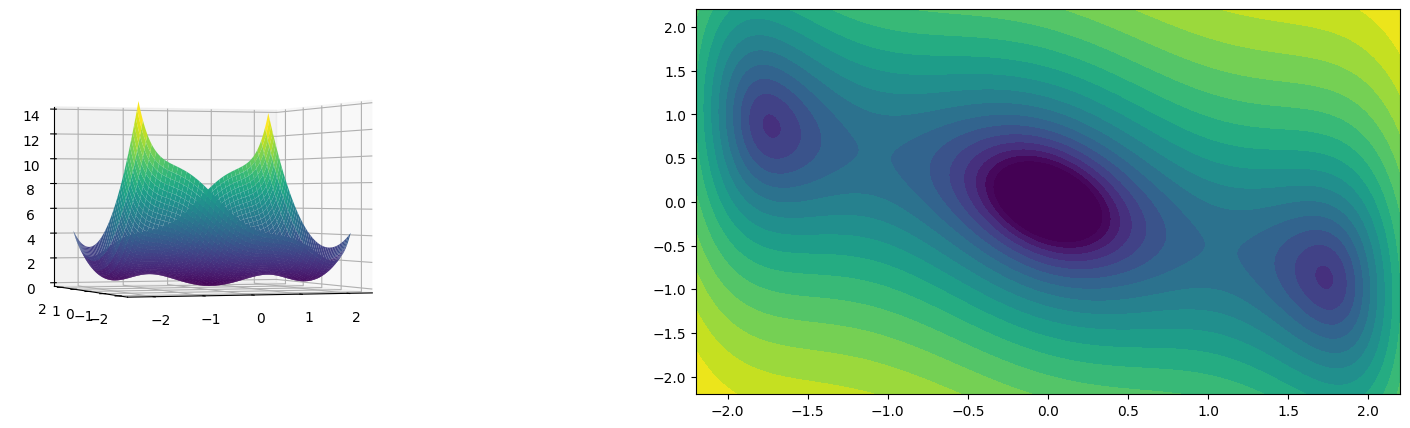

In [4]:
# vmap over x for speed when plotting
vf = vmap(f,(0,None))

# Create a grid of points
x0 = jnp.linspace(-2.2, 2.2, 400)
x1 = jnp.linspace(-2.2, 2.2, 400)
xx0, xx1 = jnp.meshgrid(x0,x1)
xx = jnp.array([xx0.flatten(), xx1.flatten()]).T
yy = vf(xx, truth).reshape(xx0.shape)

# Set up figure
fig = plt.figure(figsize=(20,5))
l, u = yy.min(), yy.max()
levels = jnp.geomspace(l, u, 50)
log_levels = jnp.log(levels)

# Adjust gridspce
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Plot the function
ax1 = fig.add_subplot(gs[0], projection = "3d")
ax1.plot_surface(xx0, xx1, yy, cmap='viridis')
ax1.view_init(0,250)

#ax.plot_surface(xx1,xx2,yy)
ax2 = fig.add_subplot(gs[1])
ax2.contourf(
    xx0,
    xx1,
    yy, 
    levels = levels,
    cmap='viridis',
    norm=matplotlib.colors.LogNorm(0.2, u)
)

# Plot set up

In [5]:
def plot_f(ax):
    x1 = jnp.linspace(-2.2, 2.2, 400)
    x2 = jnp.linspace(-2.2, 2.2, 400)
    xx1, xx2 = jnp.meshgrid(x1,x2)
    xx = jnp.array([xx1.flatten(), xx2.flatten()]).T
    yy = vf(xx, truth).reshape(xx1.shape)

    # Set up figure
    l, u = yy.min(), yy.max()
    levels = jnp.geomspace(l, u, 50)
    log_levels = jnp.log(levels)

    ax.contourf(
        xx1,
        xx2,
        yy, 
        levels = levels,
        cmap='viridis',
        norm=matplotlib.colors.LogNorm(0.3, u)
        )

    return ax

In [6]:
def plot_opts(bgd, sgd):
    fig = plt.figure(figsize=(20,5))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    ax0 = plot_f(ax0)
    ax1 = plot_f(ax1)

    colours = ["red", "blue", "green"]
    #plot bgd on ax0
    for i in range(1, len(bgd.xx)):
        s = bgd.xx[i-1]
        e = bgd.xx[i]
        ax0.annotate(
            "", xy=e, xytext=s, arrowprops=dict(arrowstyle="->")
        )
    
    #plot sgd on ax1
    for i in range(1, len(sgd.xx)):
        s = sgd.xx[i-1]
        e = sgd.xx[i]
        ax1.annotate(
            "", xy=e, xytext=s, arrowprops=dict(arrowstyle="->")
        )
    
    return fig, (ax0, ax1)

# Batch gradient descent

In [7]:
class Optimiser(ABC):
    @abstractmethod
    def compute(self, stepper, epochs=1):
        pass

    @property
    def xx(self):
        return self.stepper.xx

    @property
    def ff(self):
        return self.stepper.ff

    @property
    def dx(self):
        return self.stepper.dx

In [8]:
class BGD(Optimiser):
    def __init__(self, stepper, params, iters=50):
        self.stepper = stepper
        self.params = params
        self.iters = iters

    def compute(self, x0):
        x = x0
        for i in range(self.iters):
            x = self.stepper.step(x, self.params)

            print(
                f"Iter: {i}/{self.iters}",
                f"Step: {self.stepper.dx[-1]:.1E}",
                f"Loss: {self.stepper.ff[-1]:.3E}",
                sep="\t",
                end="\r",
            )

        print()
        return x

# Stochastic Gradient Descent

In [9]:
class SGD(Optimiser):
    def __init__(
            self,
            stepper,
            param_generator: Iterable[jnp.array],
            iters: int = None,
            epochs: int = 1
        ):
        # Store args as attrs
        self.stepper = stepper
        self.param_generator = param_generator
        self.iters = iters
        self.epochs = epochs

        # Create random seed for shuffling data
        self.key = jax.random.PRNGKey(0)

    def compute(self, x0):
        x = x0
        i = 0
        for e in range(self.epochs):
            for p in self.param_generator:
                if i == self.iters:
                    return x
                i += 1
                # Pass to stepper
                x = self.stepper.step(x, p)

                print(
                    f"Iter: {i}",
                    f"Step: {self.stepper.dx[-1]:.1E}",
                    f"Loss: {self.stepper.ff[-1]:.3E}",
                    sep="\t",
                    end="\r",
                )
            
        print()
        return x

# Steppers

In [ ]:
class Stepper(ABC):
    def __init__(self, f, *args, device = "cpu", **kwargs):
        # Add f to attributes, omit p if not in signature
        self.f = f
        self.g = grad(f, argnums=0)

        self.device = device

        # Initialise containers that track the history of the stepper
        self.ff = []  # f history
        self.gg = []
        self.xx = []  # x history
        self.dx = []  # step size history

        # Wrap step with step_wrapper; this is done during __init__
        # rather than with a decorator as step_wrapper is a method
        # and so isn't known until the class is instantiated
        self.step = self.step_wrapper(self.step)

    @abstractmethod
    def step(self):
        pass

    def step_wrapper(self, step):
        @wraps(step)
        def wrapper(x, p):
            # Record first param & function
            if len(self.xx) == 0:
                self.xx.append(x)
                self.ff.append(self.f(x, p))

            x1 = step(x, p)

            # Compute distance travelled
            euc_dist = lambda xi, x1i: jnp.linalg.norm(xi - x1i)
            dx = tree.map(euc_dist, x, x1)  # euclidian distance between x, x1
            dx_sum = sum(tree.flatten(dx)[0])

            # Update attibutes moving to cpu to free memory
            cpu = jax.devices("cpu")[0]
            to_cpu = lambda arr : jax.device_put(arr, cpu)
            self.xx.append(tree.map(to_cpu, x1))
            self.ff.append(self.f(x1, p))
            self.gg.append(self.g(x , p))
            self.dx.append(tree.map(to_cpu, dx_sum))

            return x1

        return wrapper

In [11]:
class ConstantStepper(Stepper):
    def __init__(self, f, lr=1e-1, *args, **kwargs):
        super().__init__(f, *args, **kwargs)
        self.lr = lr

    @partial(jax.jit, static_argnums=0)
    def step(self, x, *args):
        # Compute gradient and step
        g_val = self.g(x, *args)
        x1 = tree.map(lambda xi, gi: xi - self.lr * gi, x, g_val)

        return x1

In [12]:
n = 10
x0 = jnp.array([1.5,1.75])
lr = 1e-1

Iter: 9/10	Step: 1.3E-01	Loss: 5.540E-01


(<Figure size 2000x500 with 2 Axes>, (<Axes: >, <Axes: >))

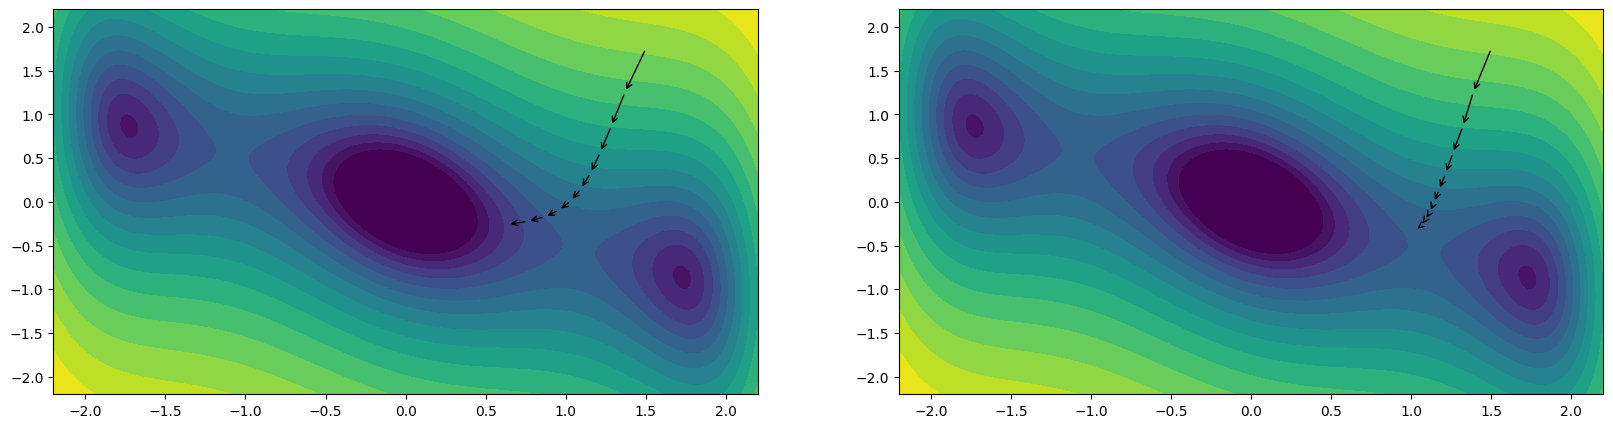

In [13]:
# BGD: p = truth
stepper = ConstantStepper(f, lr=lr)
bgd = BGD(stepper, truth, iters=n)
x = bgd.compute(x0)

# SGD: p ~ N(truth, std)
stepper = ConstantStepper(f, lr=lr)
sgd = SGD(stepper, param_generator, iters=n)
x = sgd.compute(x0)
    
# Plot
plot_opts(bgd, sgd)

In [14]:
class LineSearch(Stepper):
    def __init__(self, f, lr=1e3, c=1e-4, beta=0.9, *args, **kwargs):
        super().__init__(f, *args, **kwargs)
        self.lr = lr
        self.c = c
        self.beta = beta

    def step(self, x, p=None):
        # Compute gradient and step
        g_val = self.g(x, p)

        eta = self.lr
        while True:
            x1 = tree.map(lambda xi, gi: xi - eta * gi, x, g_val)
            gi_size = tree.map(lambda gi: (gi**2).sum(), g_val)
            g_val_size = sum(tree.flatten(gi_size)[0])

            # Armijo-Goldstein Condition
            if self.f(x1, p) <= self.ff[-1] - self.c * (eta**3) * g_val_size: #dx = -n * g => -n*(dx)**2 = -n**3 * g**2
                return x1
            else:
                eta *= self.beta

Iter: 9/10	Step: 2.1E-01	Loss: 2.459E-02


(<Figure size 2000x500 with 2 Axes>, (<Axes: >, <Axes: >))

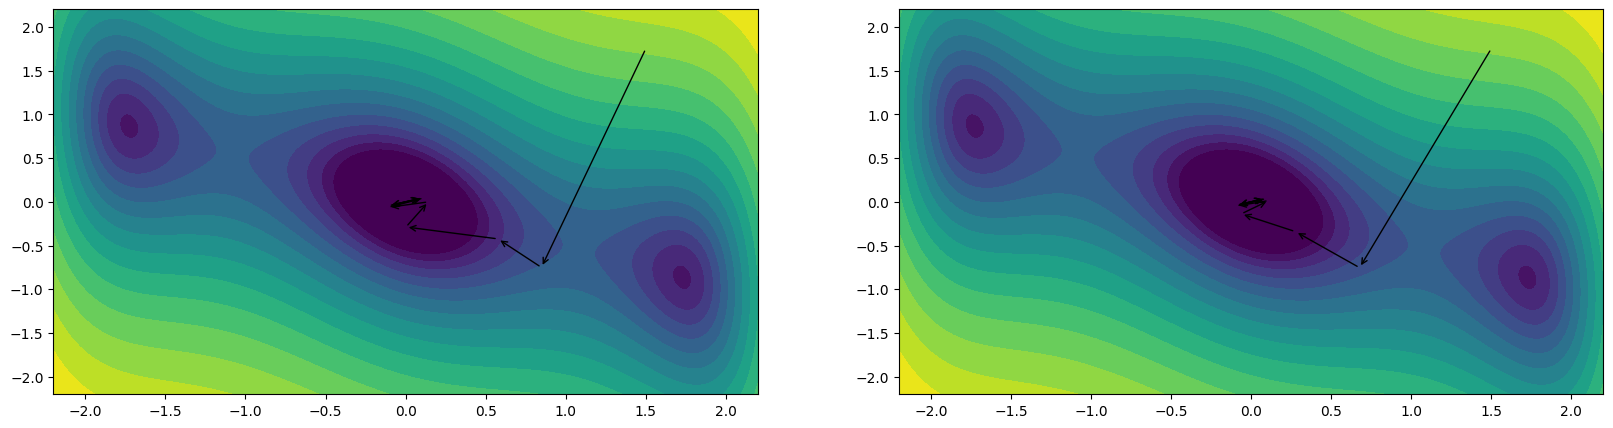

In [15]:
# BGD: p = truth
stepper = LineSearch(f, lr=5e-1)
bgd = BGD(stepper, truth, iters=n)
x = bgd.compute(x0)

# SGD: p ~ N(truth, 1)
stepper = LineSearch(f, lr=5e-1)
sgd = SGD(stepper, param_generator, iters=n)
x = sgd.compute(x0)

# Plot
plot_opts(bgd, sgd)

In [16]:
class Momentum(Stepper):
    def __init__(self, f, lr=1e-3, beta=0.9, *args, **kwargs):
        super().__init__(f, *args, **kwargs)
        self.lr = lr
        self.beta = beta

    @partial(jax.jit, static_argnums=0)
    def step(self, x, p=None):
        # Compute gradient
        g_val = self.g(x, p)

        # t0 momentum = 0
        if len(self.xx) == 1:
            self.m = g_val

        else:
            self.m = tree.map(lambda mi, gi: self.beta * mi + gi, self.m, g_val)
        x1 = tree.map(lambda xi, mi: xi - self.lr * mi, x, self.m)
        return x1

Iter: 9/10	Step: 1.3E-01	Loss: 5.540E-01


(<Figure size 2000x500 with 2 Axes>, (<Axes: >, <Axes: >))

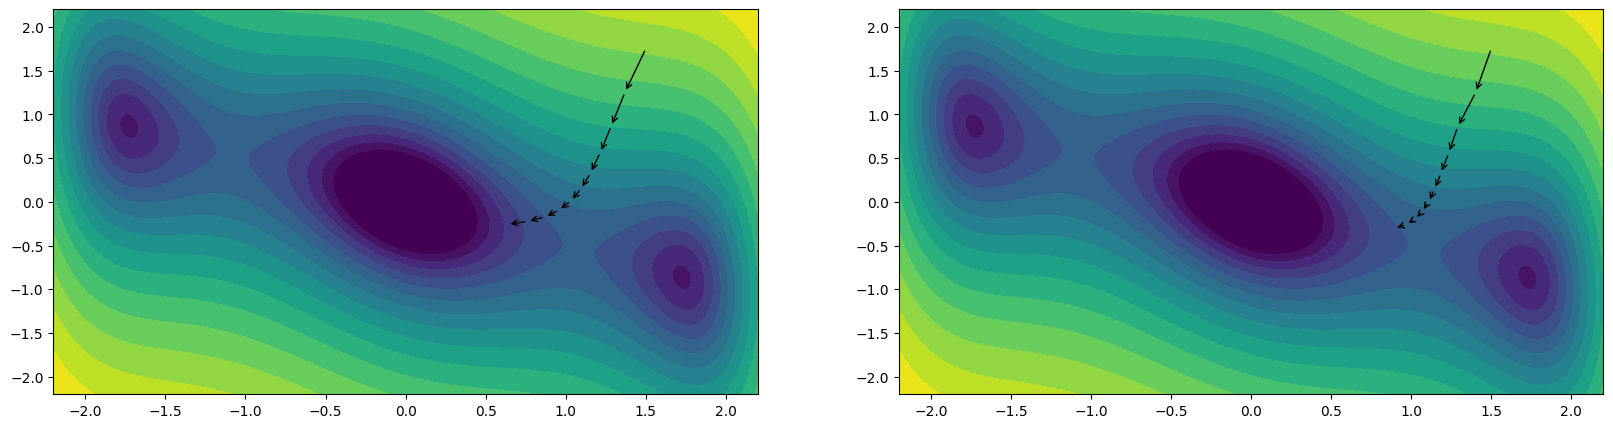

In [17]:
stepper = Momentum(f, lr=lr)
bgd = BGD(stepper, truth, iters=n)
x = bgd.compute(x0)

# SGD: p ~ N(truth, 1)
stepper = Momentum(f, lr=lr)
sgd = SGD(stepper, param_generator, iters=n)
x = sgd.compute(x0)

# Plot
plot_opts(bgd, sgd)

In [18]:
class NesterovMomentum(Stepper):
    def __init__(self, f, lr=1e-3, beta=0.9, *args, **kwargs):
        super().__init__(f, *args, **kwargs)
        self.lr = lr
        self.beta = beta

    @partial(jax.jit, static_argnums=0)
    def step(self, x, p=None):
        if len(self.xx) == 1:
            z = x
        else:
            z = tree.map(lambda x1i, xi: x1i + self.beta * (x1i - xi), x, self.xx[-2])

        # compute grad at z
        g = self.g(z, p)

        # x1 = z corrected by grad
        x1 = tree.map(lambda zi, gi: zi - self.lr * gi, z, g)

        return x1

Iter: 9/10	Step: 1.3E-01	Loss: 5.540E-01


(<Figure size 2000x500 with 2 Axes>, (<Axes: >, <Axes: >))

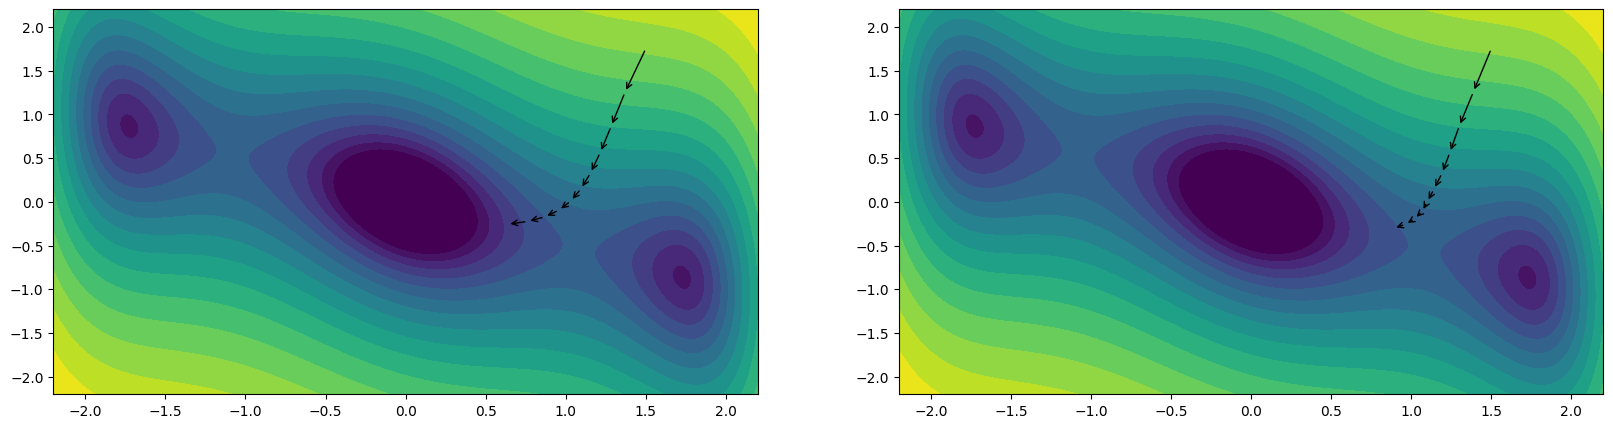

In [19]:
stepper = NesterovMomentum(f, lr=lr)
bgd = BGD(stepper, truth, iters=n)
x = bgd.compute(x0)

# SGD: p ~ N(truth, 1)
stepper = NesterovMomentum(f, lr=lr)
sgd = SGD(stepper, param_generator, iters=n)
x = sgd.compute(x0)

# Plot
plot_opts(bgd, sgd)


In [20]:
class AdaGrad(Stepper):
    def __init__(self, f, lr=1e-3, *args, **kwargs):
        super().__init__(f, *args, **kwargs)
        self.lr = lr

        self._ssg = None

    @partial(jax.jit, static_argnums=0)
    def step(self, x, p=None):
        g = self.g(x, p)
        if self._ssg is None:
            self._ssg = tree.map(lambda gi: gi**2, g)
        else:
            self._ssg = tree.map(lambda ssgi, gi: ssgi + gi**2, self._ssg, g)

        x1 = tree.map(
            lambda xi, ssgi, gi: xi - (self.lr / jnp.sqrt(ssgi + 1e-4)) * gi,
            x,
            self._ssg,
            g,
        )

        return x1

Iter: 9/10	Step: 1.4E-01	Loss: 1.375E+00


(<Figure size 2000x500 with 2 Axes>, (<Axes: >, <Axes: >))

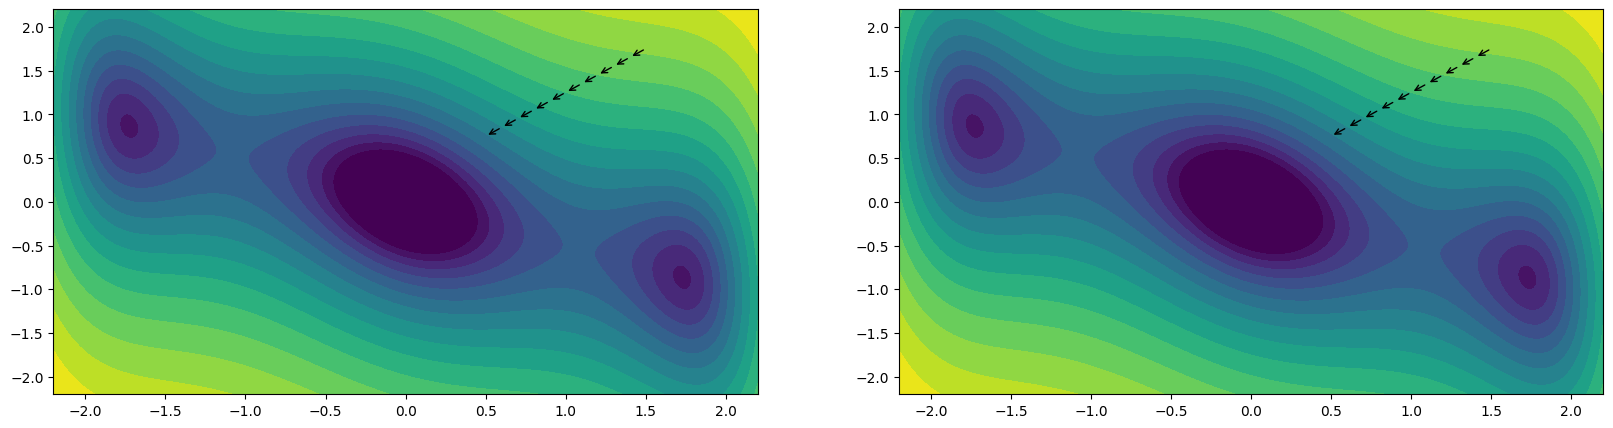

In [21]:
stepper = AdaGrad(f, lr=lr)
bgd = BGD(stepper, truth, iters=n)
x = bgd.compute(x0)

# SGD: p ~ N(truth, 1)
stepper = AdaGrad(f, lr=lr)
sgd = SGD(stepper, param_generator, iters=n)
x = sgd.compute(x0)

# Plot
plot_opts(bgd, sgd)


In [22]:
class RMSProp(Stepper):
    def __init__(self, f, lr=1e-3, beta=0.9, epsilon=1e-8, *args, **kwargs):
        super().__init__(f, *args, **kwargs)
        self.lr = lr
        self.epsilon = epsilon
        self.beta = beta

    @partial(jax.jit, static_argnums=0)
    def step(self, x, p=None):
        g = self.g(x, p)

        # initiate exponentially weighted moving average
        if len(self.xx) == 1:
            self._ewma_g = tree.map(lambda gi: gi**2, g)
        else:
            self._ewma_g = tree.map(
                lambda ewma_gi, gi: self.beta * ewma_gi + (1 - self.beta) * (gi**2),
                self._ewma_g,
                g,
            )

        x1 = tree.map(
            lambda xi, ewma_gi, gi: xi
            - (self.lr / jnp.sqrt(ewma_gi + self.epsilon)) * gi,
            x,
            self._ewma_g,
            g,
        )

        return x1

Iter: 9/10	Step: 1.4E-01	Loss: 1.375E+00


(<Figure size 2000x500 with 2 Axes>, (<Axes: >, <Axes: >))

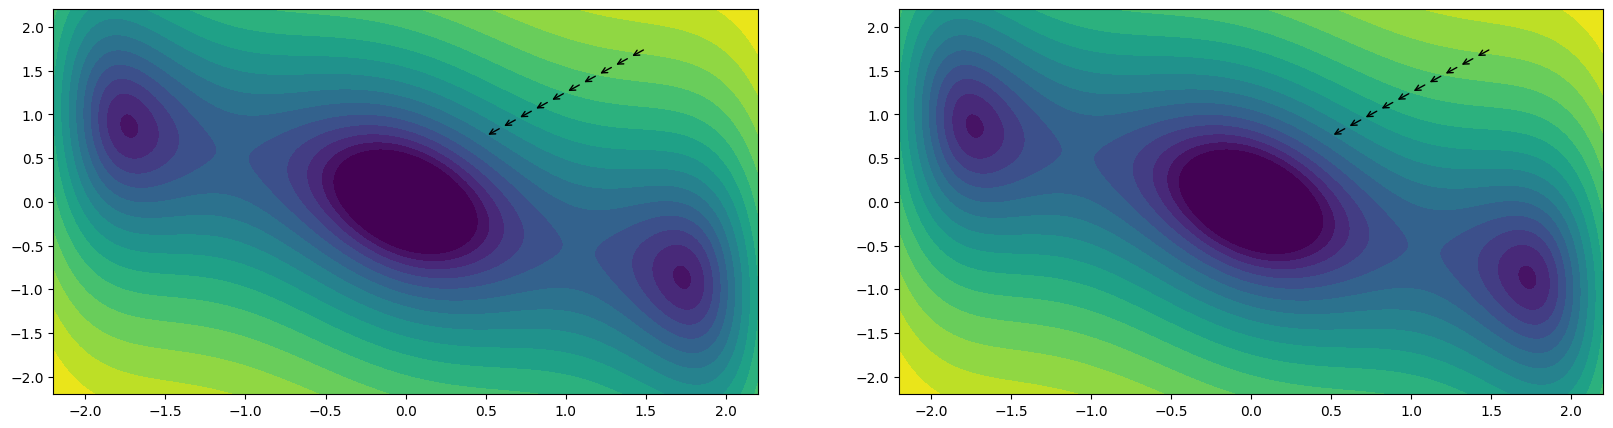

In [23]:
stepper = RMSProp(f, lr=lr)
bgd = BGD(stepper, truth, iters=n)
x = bgd.compute(x0)

# SGD: p ~ N(truth, 1)
stepper = RMSProp(f, lr=lr)
sgd = SGD(stepper, param_generator, iters=n)
x = sgd.compute(x0)

# Plot
plot_opts(bgd, sgd)


In [24]:
class AdaDelta(Stepper):
    def __init__(self, f, lr=1, beta=0.999, epsilon=1e-8, *args, **kwargs):
        super().__init__(f, *args, **kwargs)
        self.lr = lr
        self.epsilon = epsilon
        self.beta = beta

        self._ewma_g = None  # exponentially weighted moving average
        self._ewma_dx = None

    @partial(jax.jit, static_argnums=0)
    def step(self, x, p=None):
        g = self.g(x, p)

        # initialise ewma_dx and ewma_gi
        if len(self.xx) == 1:
            self._ewma_g = tree.map(lambda gi: jnp.zeros(gi.shape), g)
            self._ewma_dx = tree.map(lambda xi: jnp.zeros(xi.shape), self.xx[-1])

        else:
            self._ewma_g = tree.map(
                lambda ewma_gi, gi: self.beta * ewma_gi + (1 - self.beta) * (gi**2),
                self._ewma_g,
                g,
            )

        dx = tree.map(
            lambda gi, ewma_dxi, ewma_gi:
            (jnp.sqrt(ewma_dxi + self.epsilon) / jnp.sqrt(ewma_gi + self.epsilon))*gi,
            g,
            self._ewma_dx,
            self._ewma_g,
        )
            
        x1 = tree.map(
            lambda xi, dxi: xi - self.lr*dxi,
            x,
            dx
        )

        # Update ewma_dx after
        self._ewma_dx = tree.map(
            lambda ewma_dxi, dx: self.beta * ewma_dxi
            + (1 - self.beta) * (dx ** 2),
            self._ewma_dx,
            dx
        )

        return x1

Iter: 9/10	Step: 1.3E-01	Loss: 5.540E-01


(<Figure size 2000x500 with 2 Axes>, (<Axes: >, <Axes: >))

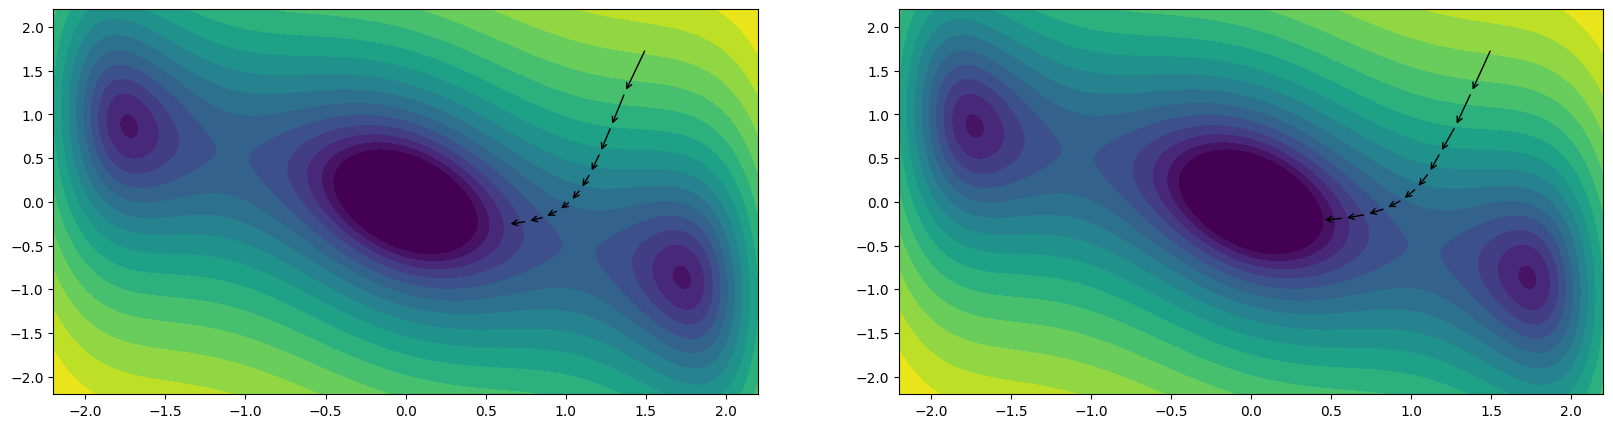

In [25]:
stepper = AdaDelta(f, lr=lr)
bgd = BGD(stepper, truth, iters=n)
x = bgd.compute(x0)

# SGD: p ~ N(truth, 1)
stepper = AdaDelta(f, lr=lr)
sgd = SGD(stepper, param_generator, iters=n)
x = sgd.compute(x0)

# Plot
plot_opts(bgd, sgd)


In [ ]:
class Adam(Stepper):
    def __init__(
        self, f, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, *args, **kwargs
    ):
        super().__init__(f, *args, **kwargs)
        self.lr = lr
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2

        self._pure_step = jax.jit(self._pure_step, static_argnums=(2,3), device=jax.devices(self.device)[0])

        self._ewma_g = None  # exponentially weighted moving average
        self._ewma_dx = None

    @staticmethod
    def _pure_step(x, p, f, g, m, _ewma_g, beta1, beta2, lr, epsilon):
        # Get grad
        g_val = g(x, p)

        # Update momentum and ewma_g
        m = tree.map(
            lambda mi, gi: beta1 * mi + (1 - beta1) * gi, 
            m, 
            g_val
        )

        _ewma_g = tree.map(
            lambda ewma_gi, gi: beta2 * ewma_gi + (1 - beta2) * (gi**2),
            _ewma_g,
            g_val,
        )

        # Compute x1
        x1 = tree.map(
            lambda xi, mi, ewma_gi: xi - lr*(1 / jnp.sqrt(ewma_gi + epsilon))*mi,
            x,
            m,
            _ewma_g
        )

        return x1, m, _ewma_g

    def step(self, x, p=None):     
        # Initiate m and ewma_g at 0
        if len(self.xx) == 1:
            self.m = tree.map(  
                lambda pi: np.zeros(pi.shape), x
            )
            self._ewma_g = tree.map(
                lambda pi: np.zeros(pi.shape), x
            )
        
        x1, self.m, self._ewma_g = self._pure_step(x, p, self.f, self.g, self.m, self._ewma_g, self.beta1, self.beta2, self.lr, self.epsilon)

        return x1

Iter: 9/10	Step: 3.5E-01	Loss: 6.210E-01


(<Figure size 2000x500 with 2 Axes>, (<Axes: >, <Axes: >))

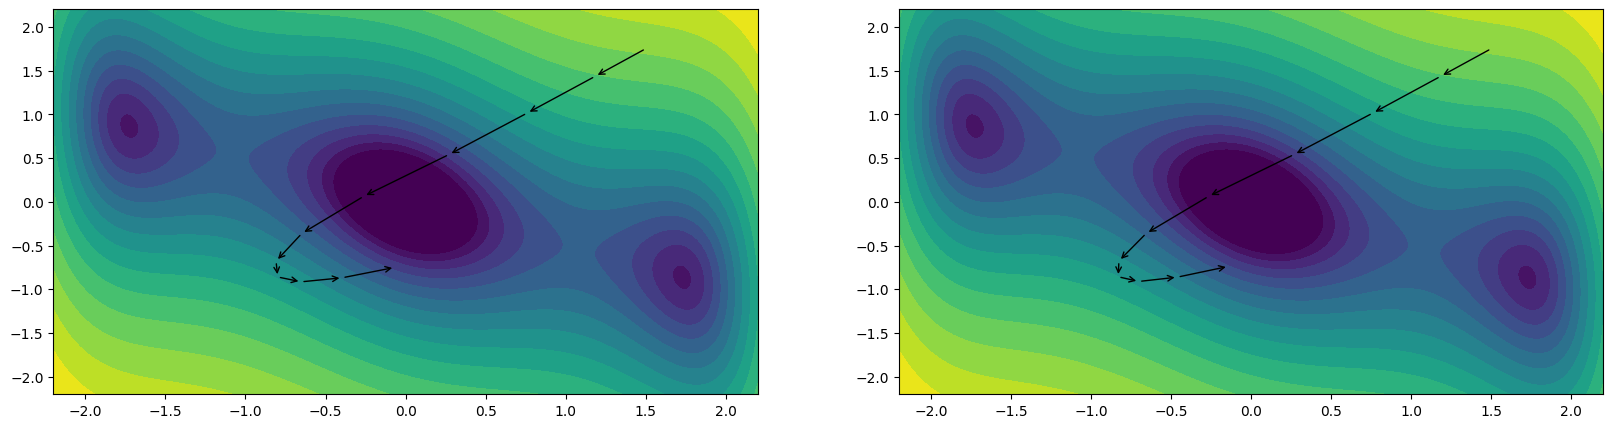

In [29]:
stepper = Adam(f, lr=lr)
bgd = BGD(stepper, truth, iters=n)
x = bgd.compute(x0)

# SGD: p ~ N(truth, 1)
stepper = Adam(f, lr=lr)
sgd = SGD(stepper, param_generator, iters=n)
x = sgd.compute(x0)

# Plot
plot_opts(bgd, sgd)